# Merfish to merfish registration with tools


In [1]:
# note for merfish to merfish she used teh same slice I aligned to visium
# and then another one (S2R2)
# S2R3 and S2

In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
import glob
import torch

from scipy.stats import rankdata
import nrrd
import time

import tools

import imp
imp.reload(tools)

<module 'tools' from '/home/dtward/Documents/UCLA/analyze_merfish/spatial_transcriptomics_registration/tools.py'>

In [3]:
files = glob.glob('/mnt/data/merfish/OneDrive_1_8-5-2021/*metadata*.csv.gz')
files.sort()
files

['/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_metadata_S1R1.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate2_cell_metadata_S1R2.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate3_cell_metadata_S1R3.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate1_cell_metadata_S2R1.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice3_Replicate1_cell_metadata_S3R1.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_Brai

<IPython.core.display.Javascript object>


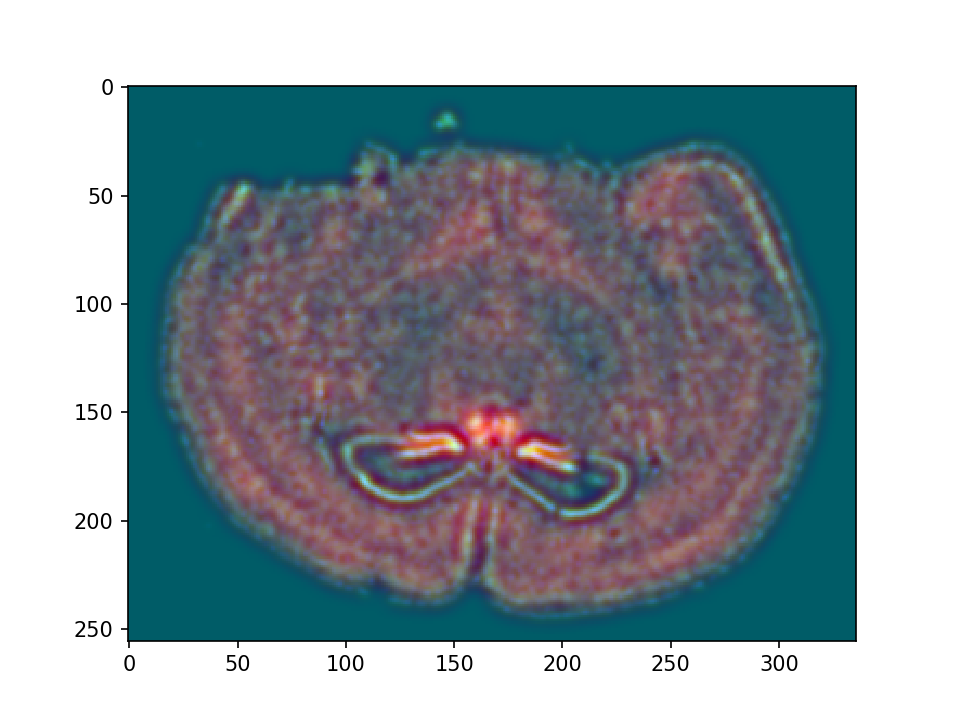

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


In [4]:

fname = files[-4]

names = os.path.splitext(fname)
if names[1] == '.gz':
    names = os.path.splitext(names[0])
outname = names[0] + '_with_structure_id_v02.csv'


df = pd.read_csv(fname.replace('by_gene','metadata'))
xI = np.array(df['center_x'])
yI = np.array(df['center_y'])
vI = np.array(df['volume'])


imp.reload(tools)
blur = [2.0,1.0,0.5]

draw = 10000
wavelet_magnitude = True
dx = 30.0
use_windowing = True
XI,YI,I,fig = tools.rasterize(xI,yI,dx=dx,blur=blur,draw=draw, wavelet_magnitude=wavelet_magnitude, use_windowing=use_windowing)

<IPython.core.display.Javascript object>


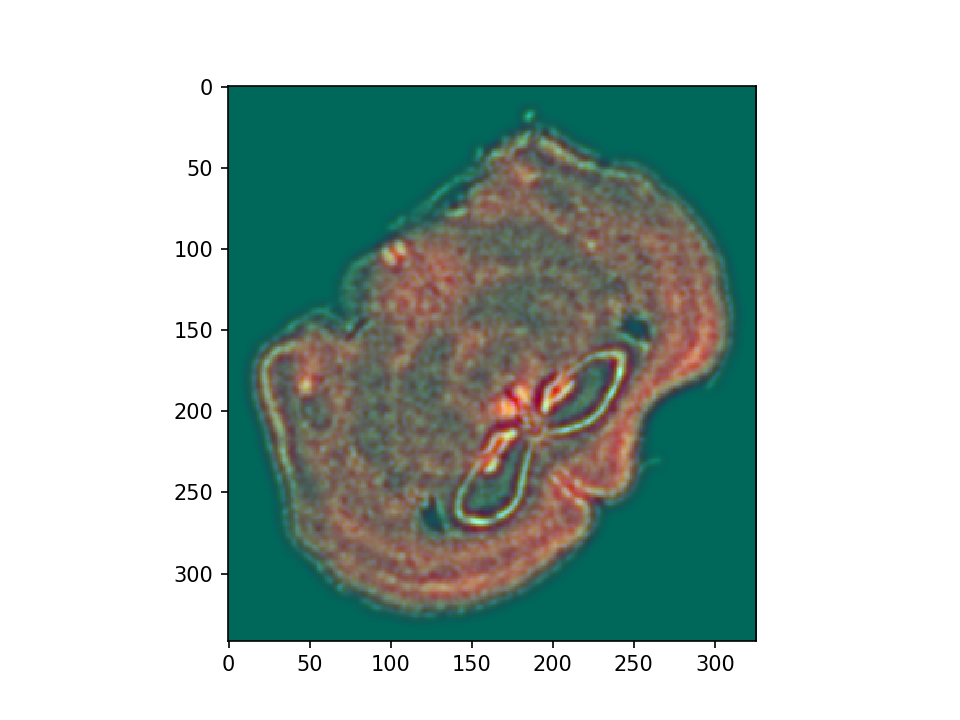

0 of 84172
10000 of 84172
20000 of 84172
30000 of 84172
40000 of 84172
50000 of 84172
60000 of 84172
70000 of 84172
80000 of 84172
84171 of 84172


In [5]:
fname = files[-5]

names = os.path.splitext(fname)
if names[1] == '.gz':
    names = os.path.splitext(names[0])
outname = names[0] + '_with_structure_id_v02.csv'


df = pd.read_csv(fname.replace('by_gene','metadata'))
xJ = np.array(df['center_x'])
yJ = np.array(df['center_y'])
vJ = np.array(df['volume'])


XJ,YJ,J,fig = tools.rasterize(xJ,yJ,dx=dx,blur=blur,draw=draw, wavelet_magnitude=wavelet_magnitude, use_windowing=use_windowing)

# Declare some points and plot them

In [ ]:
pointsI = None
pointsJ = None
# note points should be in row column not x y, and should be Nx2 for N points
pointsI = np.array([[6500.0,5000.0],[4892.0,4793.0],[4982.0,5508.0],[865.0,8101.0],[1256.0,1618.0]])
pointsJ = np.array([[7500,7000.0],[6238.0,5360.0],[5848.0,5880.0],[640.0,5663.0],[5053.0,675.0]])
extentI = tools.extent_from_x((YI,XI))
extentJ = tools.extent_from_x((YJ,XJ))
fig,ax = plt.subplots(1,2)
ax[0].imshow((I/np.max(I)).transpose(1,2,0),extent=extentI)
ax[1].imshow((J/np.max(J)).transpose(1,2,0),extent=extentJ)
ax[0].scatter(pointsI[:,1],pointsI[:,0])
ax[1].scatter(pointsJ[:,1],pointsJ[:,0])

<IPython.core.display.Javascript object>


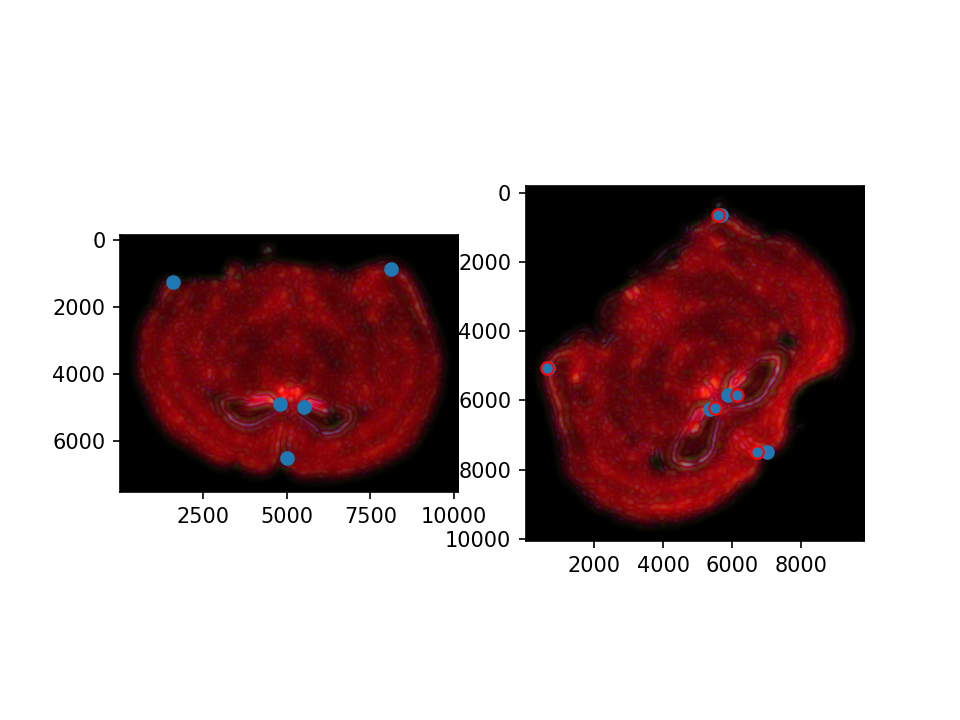

In [8]:
L,T = tools.L_T_from_points(pointsI,pointsJ)    
ApointsI = (L@pointsI.T).T + T
fig,ax = plt.subplots(1,2)
ax[0].imshow((I/np.max(I)).transpose(1,2,0),extent=extentI)
ax[1].imshow((J/np.max(J)).transpose(1,2,0),extent=extentJ)
ax[0].scatter(pointsI[:,1],pointsI[:,0])
ax[1].scatter(pointsJ[:,1],pointsJ[:,0])
ax[1].scatter(ApointsI[:,1],ApointsI[:,0],fc=None,ec='r')

# Run the mapping code

<IPython.core.display.Javascript object>


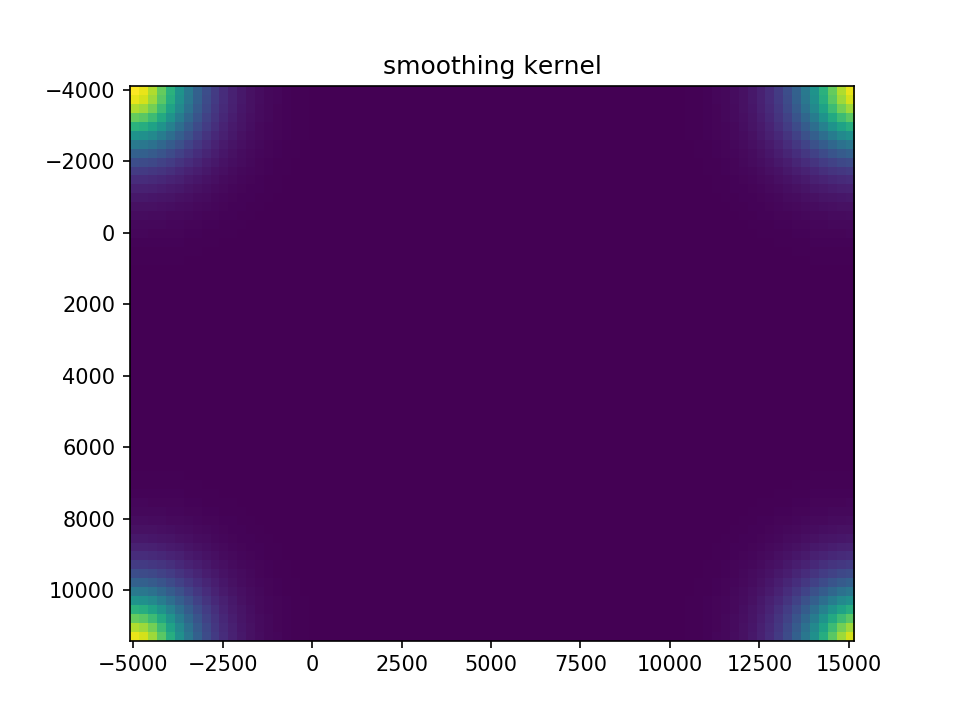

<IPython.core.display.Javascript object>


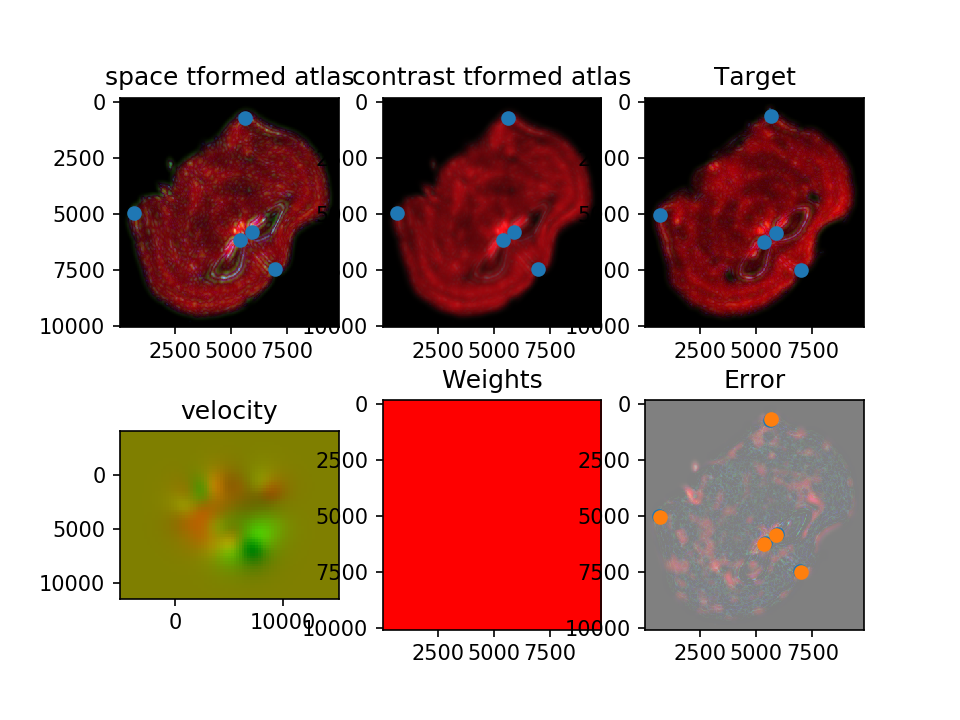

<IPython.core.display.Javascript object>


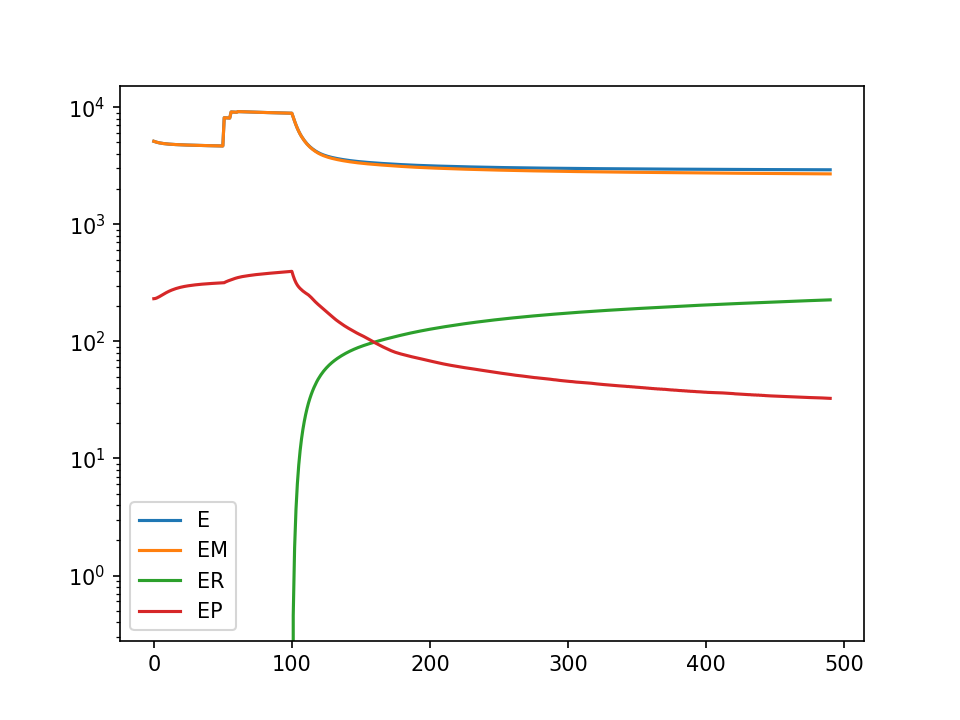

In [23]:
device = 'cpu'
imp.reload(tools)
params = {'L':L,'T':T,
          'pointsI':pointsI,
          'pointsJ':pointsJ,
          'niter':500,
          'device':device,
          }
A,v,xv = tools.LDDMM([YI,XI],I,[YJ,XJ],J,
            **params)

# Restart the code using previous outputs

/home/dtward/Documents/UCLA/analyze_merfish/spatial_transcriptomics_registration/tools.py:518: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
/home/dtward/Documents/UCLA/analyze_merfish/spatial_transcriptomics_registration/tools.py:519: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
/home/dtward/Documents/UCLA/analyze_merfish/spatial_transcriptomics_registration/tools.py:536: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

<IPython.core.display.Javascript object>


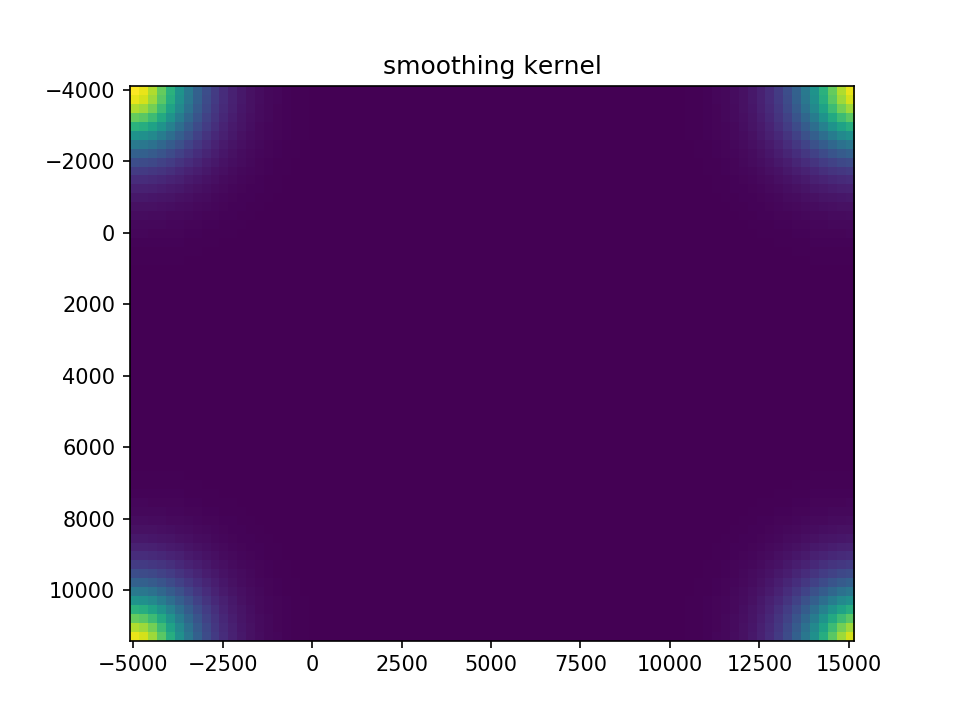

<IPython.core.display.Javascript object>


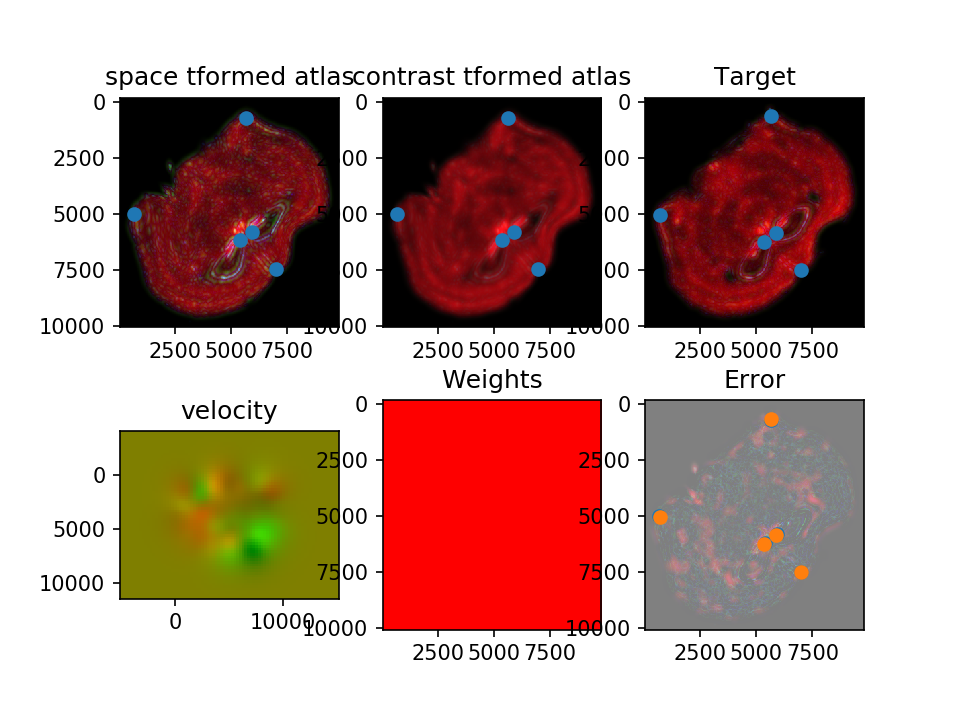

<IPython.core.display.Javascript object>


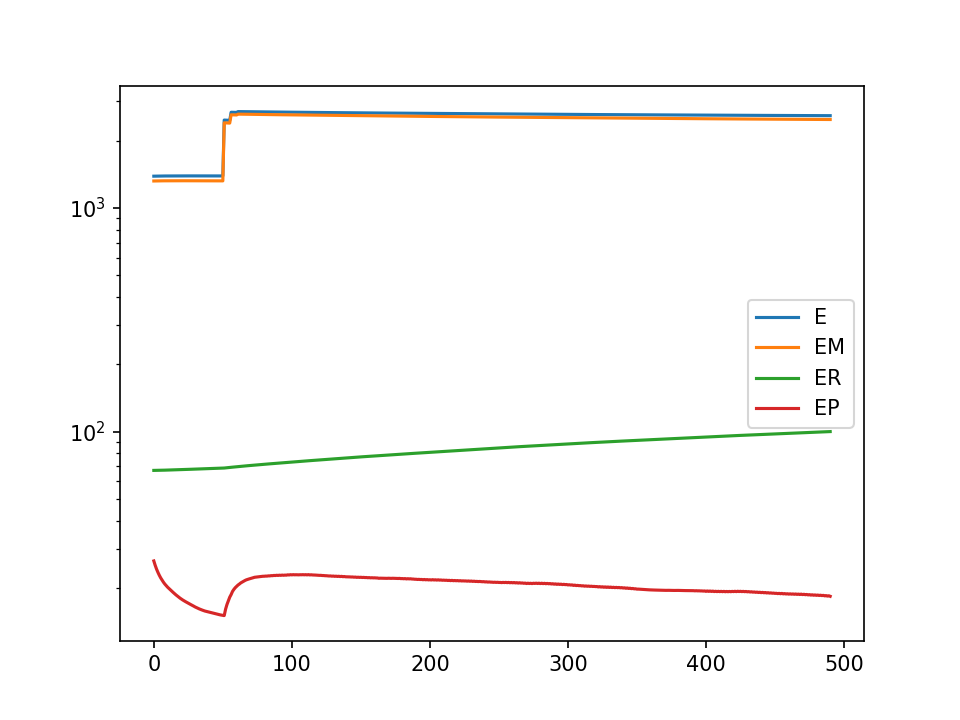

In [21]:
# test restarting
params1 = dict(params)
params1['v'] = v
params1['xv'] = xv
params1['L'] = A[:2,:2]
params1['T'] = A[:2,-1]
params1['diffeo_start'] = 0
A,v,xv = tools.LDDMM([YI,XI],I,[YJ,XJ],J,
            **params1)

In [11]:
# apply the transforms to the points
